In [2]:
# from tensorflow_docs.vis import embed
from tensorflow import keras
# from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import imageio
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense,Flatten,LSTM,Dropout,TimeDistributed,BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from keras.preprocessing import image
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [7]:
df = pd.read_csv("../input/2022-2-23-data/2022_2_23_data.csv").astype('float32') 
# replace the first column name as label
df.rename(columns={'0':'label'}, inplace=True)
X = df.drop('label',axis = 1)
y = df['label']

# print(y.at[335])

In [8]:
standard_scaler = MinMaxScaler()
standard_scaler.fit(X)
X = standard_scaler.transform(X)
X

array([[0.76923084, 0.52528095, 0.22969198, ..., 0.6387284 , 0.73195887,
        0.49318814],
       [0.67692304, 0.6292136 , 0.4537816 , ..., 0.3121388 , 0.7345362 ,
        0.7057221 ],
       [0.6051283 , 0.37640452, 0.37815142, ..., 0.64450884, 0.48453617,
        0.19891024],
       ...,
       [0.476923  , 0.5730336 , 0.4817927 , ..., 0.46820807, 0.36855674,
        0.63487744],
       [0.5461538 , 0.70786524, 0.7591038 , ..., 0.5664742 , 0.5360825 ,
        0.49046326],
       [0.60769224, 0.6601124 , 0.5014007 , ..., 0.48843932, 0.6108248 ,
        0.4795642 ]], dtype=float32)

In [9]:
y.shape

(3878,)

In [10]:
temp=[]
temp2=[]
for i in tqdm(range(0,df.shape[0]-18,1)):
    temp.append(X[i:i+18])
    avg=sum(y[i:i+18])/len(y[i:i+18])
    if avg>0.66 and avg<=1.33:
        temp2.append(1)
    else:
        temp2.append(0)
X=np.array(temp)
y=np.array(temp2)

100%|██████████| 3860/3860 [00:00<00:00, 12123.64it/s]


In [11]:
X = X.reshape(X.shape[0],18, 64, 32, 1).astype('float32')
print(X.shape)

(3860, 18, 64, 32, 1)


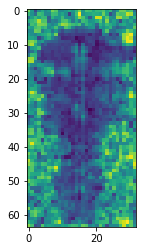

In [12]:
plt.imshow(X[0][0])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

In [ ]:
# y_train = np_utils.to_categorical(y_train)
# y_test = np_utils.to_categorical(y_test)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3088, 18, 64, 32, 1)
(772, 18, 64, 32, 1)
(3088,)
(772,)


In [15]:
keras.backend.clear_session()

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [17]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [18]:
model = Sequential()
model.add(TimeDistributed(Conv2D(16,(2,2),activation='relu')
,input_shape=(18,64,32,1)))
# ,kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)
# model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(TimeDistributed(Conv2D(32,(3,3),activation='relu')
,input_shape=(18,64,32,1)))
model.add(TimeDistributed(MaxPooling2D(2,2)))
# model.add(TimeDistributed(Conv2D(64,(3,3),activation='relu')))
# model.add(TimeDistributed(MaxPooling2D(2,2)))
# model.add(TimeDistributed(Conv2D(128,(3,3),activation='relu')))
# model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(TimeDistributed(Flatten()))
# model = Sequential()
# model.add(TimeDistributed(CNN))
model.add(LSTM(64))
model.add(Dropout(0.5))
# model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
model.summary()

2022-02-28 10:00:57.768835: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 18, 63, 31, 16)    80        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 18, 31, 15, 16)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 29, 13, 32)    4640      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 14, 6, 32)     0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 2688)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                704768    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

In [19]:
# datapath = os.path.join('..', 'data', 'final')
# data = Dataset(X_train, 
#                reduce_frames=True, 
#                batch_size=32, 
#                test=False)
# data=X_train.batch(batch_size=2)
# model.fit(ds,batch_size=32 , epochs=18, verbose=1)
model.fit(X_train,y_train,batch_size=128 , epochs=30, verbose=1,validation_split =0.25,callbacks=[early_stopping])
# model.fit(X_train,y_train,batch_size=128 , epochs=100, verbose=1,validation_split =0.25)

2022-02-28 10:01:08.141674: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
19/19 [==============================] - 17s 712ms/step - loss: 0.6954 - accuracy: 0.5980 - val_loss: 0.6540 - val_accuracy: 0.6412
Epoch 2/30
19/19 [==============================] - 13s 688ms/step - loss: 0.6628 - accuracy: 0.6222 - val_loss: 0.6437 - val_accuracy: 0.6412
Epoch 3/30
19/19 [==============================] - 13s 665ms/step - loss: 0.6508 - accuracy: 0.6291 - val_loss: 0.6304 - val_accuracy: 0.6412
Epoch 4/30
19/19 [==============================] - 13s 664ms/step - loss: 0.6349 - accuracy: 0.6295 - val_loss: 0.5747 - val_accuracy: 0.6464
Epoch 5/30
19/19 [==============================] - 13s 686ms/step - loss: 0.5961 - accuracy: 0.6485 - val_loss: 0.5248 - val_accuracy: 0.7267
Epoch 6/30
19/19 [==============================] - 13s 659ms/step - loss: 0.5593 - accuracy: 0.6852 - val_loss: 0.5054 - val_accuracy: 0.7370
Epoch 7/30
19/19 [==============================] - 12s 655ms/step - loss: 0.5449 - accuracy: 0.7111 - val_loss: 0.5009 - val_accuracy: 0.7552

In [ ]:
# model.evaluate(X_test, y_test, batch_size=32)

In [20]:
# print(y_test.shape)
# print(y_pred.shape)

(772,)


NameError: name 'y_pred' is not defined

In [21]:
np.argmax(y_test)

1

In [22]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred = np.asarray(y_pred).reshape(-1)
y_pred_class = y_pred > 0.5

print(classification_report(y_test, y_pred_class))

13/13 [==============================] - 2s 94ms/step
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       500
           1       0.76      0.94      0.85       272

    accuracy                           0.88       772
   macro avg       0.87      0.89      0.87       772
weighted avg       0.89      0.88      0.88       772

